<a href="https://colab.research.google.com/github/Alamsyah-WM/Predict-DNA-binding-protein-with-ML-and-DL/blob/main/BioInformatik_UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Library

In [6]:
import pandas as pd  # For data manipulation
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For advanced plotting
from sklearn.model_selection import train_test_split  # For splitting datasets
from sklearn.preprocessing import StandardScaler  # For scaling features

##Load Dataset

In [15]:
pdb = pd.read_csv('/content/PDB1063-186.csv')
uniswiss = pd.read_csv('/content/UniSwiss.csv')

print("Raw PDB Dataset:")
print(pdb.head())

print("\nRaw UniSwiss Dataset:")
print(uniswiss.head())

Raw PDB Dataset:
  identifier                                           sequence  label    set
0      1AKHB  TKPYRGHRFTKENVRILESWFAKNIENPYLDTKGLENLMKNTSLSR...      1  train
1      1B6WA  MELPIAPIGRIIKDAGAERVSDDARITLAKILEEMGRDIASEAIKL...      1  train
2      1C1KA  MIKLRMPAGGERYIDGKSVYKLYLMIKQHMNGKYDVIKYNWCMRVS...      1  train
3      1C6VX  QQSKNSKFKNFRVYYREGRDQLWKGPGELLWKGEGAVLLKVGTDIK...      1  train
4      1C6VD  IHGQVNSDLGTWQMDCTHLEGKIVIVAVHVASGFIEAEVIPQETGR...      1  train

Raw UniSwiss Dataset:
   identifier                                           sequence  label    set
0      P08956  MMNKSNFEFLKGVNDFTYAIACAAENNYPDDPNTTLIKMRMFGEAT...      1  train
1      P27235  MPPQRSRRRKRASATQLYQTCKASGTCPPDVIPKVEGTTLADKILQ...      1  train
2      P0AD01  MINVLIIDDDAMVAELNRRYVAQIPGFQCCGTASTLEKAKEIIFNS...      1  train
3  A0A024B7I0  MAYMCADSGNLMAIAQQVIKQKQQQEQQQQQSHHPQQQFLGLNPFS...      1  train
4      F4I443  MAEFTNMLMNPWVLHLQKLELELKCPLCLKLLNRPVLLPCDHVFCD...      1  train


##Understanding Dataset

In [42]:
# Get general information about the datasets
print("Total PDB Sequence:", len(pdb))
print("Total Uniswiss Sequence:", len(uniswiss))

print("\nAverage PDB Sequence Length:", int(pdb['sequence_length'].mean()))
print("Average Uniswiss Sequence Length:", int(uniswiss['sequence_length'].mean()))

print("\nMinimum PDB Sequence Length:", pdb['sequence_length'].min())
print("Maximum PDB Sequence Length:", pdb['sequence_length'].max())

print("\nMinimum Uniswiss Sequence Length:", uniswiss['sequence_length'].min())
print("Maximum Uniswiss Sequence Length:", uniswiss['sequence_length'].max())

# Check for missing values
print("\nMissing Values in PDB Dataset:")
print(pdb.isnull().sum())
print("\nMissing Values in UniSwiss Dataset:")
print(uniswiss.isnull().sum())

# Check the label distribution (assuming 'label' column exists)
print("\nLabel Distribution in PDB Dataset:")
print(pdb['label'].value_counts())

print("\nLabel Distribution in UniSwiss Dataset:")
print(uniswiss['label'].value_counts())

Total PDB Sequence: 1249
Total Uniswiss Sequence: 9762

Average PDB Sequence Length: 243
Average Uniswiss Sequence Length: 475

Minimum PDB Sequence Length: 50
Maximum PDB Sequence Length: 1323

Minimum Uniswiss Sequence Length: 50
Maximum Uniswiss Sequence Length: 8515

Missing Values in PDB Dataset:
identifier         0
sequence           0
label              0
set                0
sequence_length    0
dtype: int64

Missing Values in UniSwiss Dataset:
identifier         0
sequence           0
label              0
set                0
sequence_length    0
dtype: int64

Label Distribution in PDB Dataset:
label
0    638
1    611
Name: count, dtype: int64

Label Distribution in UniSwiss Dataset:
label
1    4881
0    4881
Name: count, dtype: int64


#**Exploraty Data Analysis**
##Objective
1. Analyse sequence length distribution
2. Amino Acid Composition with 20 Frequency
3. Compositional differences between DNA Binding vs non-binding proteins


###1. Sequence lenght Distribution

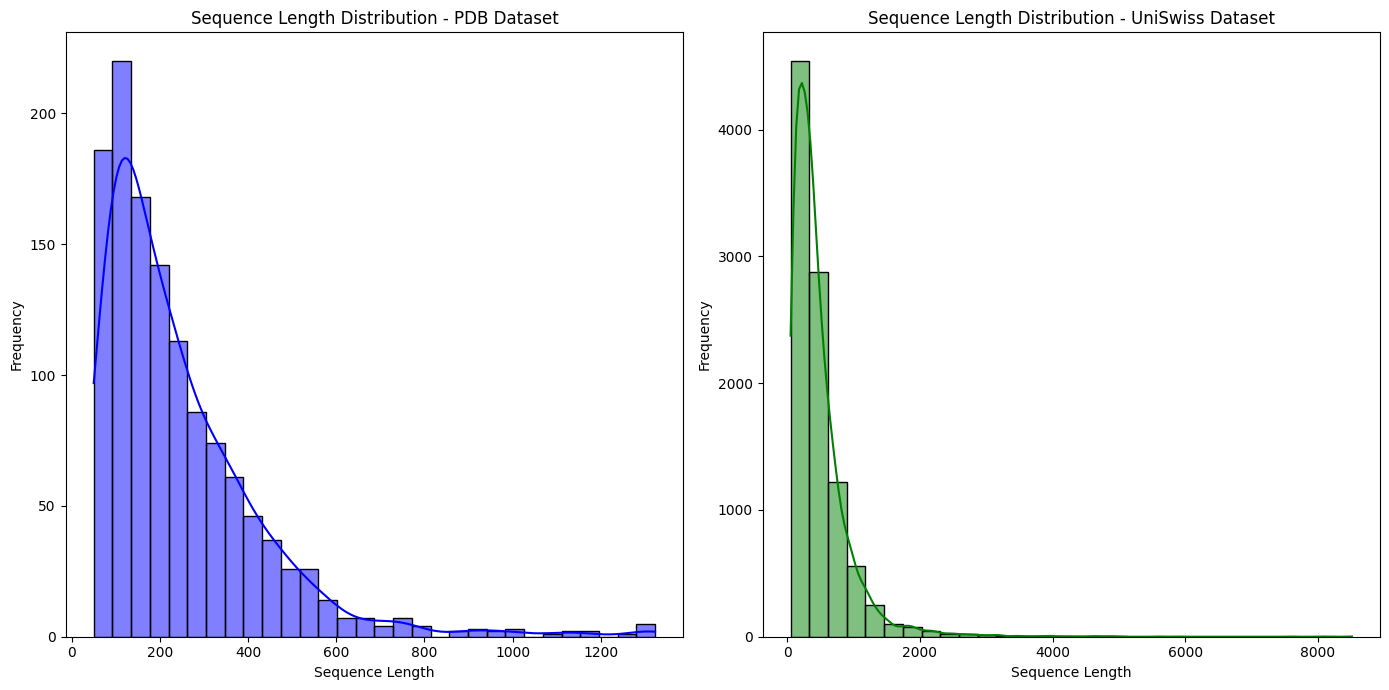

In [31]:
# Function to calculate sequence length
def calculate_sequence_length(dataset, seq_column):
    return dataset[seq_column].apply(len)


# PDB Dataset
pdb['sequence_length'] = calculate_sequence_length(pdb, 'sequence')

# UniSwiss Dataset
uniswiss['sequence_length'] = calculate_sequence_length(uniswiss, 'sequence')

# Plot sequence length distribution for both datasets
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.histplot(pdb['sequence_length'], kde=True, color='blue', bins=30)
plt.title('Sequence Length Distribution - PDB Dataset')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(uniswiss['sequence_length'], kde=True, color='green', bins=30)
plt.title('Sequence Length Distribution - UniSwiss Dataset')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
